# Interactive Daisyworld
Interactive daisyworld is a python implementation of the famous [daisyworld computer simulation](https://en.wikipedia.org/wiki/Daisyworld). It describes a hypothetical world orbiting a star, whose radiant energy slowly increases over time. The world has two types of daisies (black and white) as it's only life form. The population of daisies can modify the worlds albedo and thereby migitage the effects arising from the increasing radiant energy of the star. The concept was first described by [Watson and Lovelock (1983)](https://doi.org/10.1111%2Fj.1600-0889.1983.tb00031.x) [1]

[1] Watson, A.J.; J.E. Lovelock (1983). "Biological homeostasis of the global environment: the parable of Daisyworld". Tellus B. 35 (4): 286–9.


In [79]:
# -----------------
# import libraries
# -----------------

# standard libraries
# -----

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
from io import BytesIO

In [139]:
# helper functions
# -----

def plot_world_trajectory(tmax, dt, daisydict, X, planet_temp):
    palette = sns.color_palette("Blues",10)
    tr = np.arange(0, tmax+dt, dt)
    #print(tr.shape)
    plt.subplot(2, 1, 1)
    for i, daisyname in enumerate(daisydict):
        plt.plot(tr, daisydict[daisyname], '-', color=palette[i+3+i*3], label=daisyname)
    plt.plot(tr, X, 'g--', label='fertile')
    plt.title('Daisyworld Output')
    plt.ylabel('% of area\ncovered with daisies')
    plt.legend()


    plt.subplot(2, 1, 2)
    plt.plot(tr, planet_temp, 'r-')
    plt.xlabel('time(yr)')
    plt.ylabel('temperature\nof the planet')
    
    #plt.legend()
    plt.show()



In [140]:
# constants
# -----

SOLCONST = 917.0      # J/(m^2*s)
STEFBOLTZ = 5.67e-8   # J/(m^2*s*degK^4)

In [141]:
# -----------------
# world classes
# -----------------

# this is your basic class for your daisyworld
class World(object):
    def __init__(self, name, fert=1.0, gralbedo=0.5, luminosity=0.5, lumacc=0.02, solconst=SOLCONST):
        self.name = name
        self.fert = fert
        self.gralbedo = gralbedo
        self.luminosity = luminosity
        self.lumacc = lumacc
        self.solconst = solconst
        
        self.time = 0.
        self.daisies = []
    
    def add_daisy(self, Daisy):
        self.daisies.append(Daisy)        
        area = 0
        for daisy in self.daisies:
            area += daisy.area
        if area > self.fert:
            self.daisies.pop()
            raise ValueError("daisies cannot occupy more than 100% of fertile area")
        else:
            pass
    
    def reset(self):
        self.time = [self.time[0]]
        self.luminosity = [self.luminosity[0]]
        for daisy in self.daisies:
            daisy.reset()
        pass
        
    def plot(self):
        pass
    
    def simulate_timestep(self, dt=0.2):
        self.X = self.fert
        for daisy in self.daisies:
            self.X -= daisy.area
        
        # planetary temperature
        # -----
        
        alb_planet = 0.
        remaining_frac = 1.
        for daisy in self.daisies:
            alb_planet += daisy.area * daisy.albedo
            remaining_frac -= daisy.area
        alb_planet += remaining_frac * self.gralbedo
        
        
        #self.luminosity = np.sin(np.pi/75 * self.time - np.pi) * 0.4 + 1.25    
        self.luminosity += self.lumacc * dt                 # unitless
        solflux = self.solconst * self.luminosity           # J/(m^2*s)
        q = (0.2 * solflux) / STEFBOLTZ                     # unitless
        
        self.planet_temp = (((solflux * (1 - alb_planet)) / STEFBOLTZ)**0.25) - 273.15
        
        # daisy temperature and growth
        # -----
        
        for daisy in self.daisies:
            daisy.temperature = (((q * (alb_planet - daisy.albedo)) + ((self.planet_temp + 273.16)**4))**(0.25)) - 273.16
            
            if (daisy.temperature > daisy.UT or daisy.temperature < daisy.LT):
                beta = 0.0
            else:
                beta = (1.0 - 0.003265 * ((((daisy.UT-daisy.LT)/2. + daisy.LT) - daisy.temperature)**2))
                
            dgrowth = daisy.area * self.X * beta
            
            if (daisy.area > daisy.seeds):
                ddeath = daisy.area * daisy.death_rate
            else:
                ddeath = 0.
            
            if (daisy.mutation > 0):
                daisy.mutate()
            
            
            # Quantity in each reservoir = quantity at previous timestep + (inflows - outflows) * dt    
            daisy.area += (dgrowth - ddeath) * dt
            
        self.time += dt
        
        return self.time, self.X, self.planet_temp, solflux
    
    

class Daisy(object):
    def __init__(self, name, albedo=0.5, area=0.001, death_rate=0.3, LT=5.0, UT=40.0, seeds=0.001, mutation=0):
        self.name = name
        self.albedo = albedo
        self.death_rate = death_rate
        self.UT = UT
        self.LT = LT
        self.seeds = seeds
        self.mutation = mutation
        
        self.temperature = 0.0
        self.area = area

    
    def __str__(self):
        return 'Daisy Object, name:{}'.format(self.name)
    
    def reset():
        self.temperature = [self.temperature[0]]
        self.beta = [self.beta[0]]
        self.area = [self.area[0]]         
    
    def mutate(self, rate=1.00):
        self.albedo = self.albedo if np.random.random() < self.mutation else self.albedo + self.albedo * rate * self.area * (np.random.random()*2 - 1)
        self.albedo = np.clip(self.albedo, 0., 1.)
        
        self.death_rate = self.death_rate if np.random.random() < self.mutation else self.death_rate + self.death_rate * rate * self.area * (np.random.random()*2 - 1)
        self.death_rate = np.clip(self.death_rate, 0., 1.)

        self.UT = self.UT if np.random.random() < self.mutation else self.UT + self.UT * rate * self.area * (np.random.random()*2 - 1)
        self.UT = np.clip(self.UT, -273.15, None)

        self.LT = self.LT if np.random.random() < self.mutation else self.LT + self.LT * rate * self.area * (np.random.random()*2 - 1)
        self.LT = np.clip(self.LT, -273.15, self.UT)

In [142]:
# world building
# -----

def build_basicworld(fertility=1.0, ltemp=5., utemp=40., walb=0.75, balb=0.25):
    
    daisyworld = World('daisyworld', fert=fertility)
    white_daisy = Daisy('white', albedo=walb, LT=ltemp, UT=utemp)
    black_daisy = Daisy('black', albedo=balb, LT=ltemp, UT=utemp)
    daisyworld.add_daisy(white_daisy)
    daisyworld.add_daisy(black_daisy)
    
    return daisyworld

In [143]:
# simulation loop
# -----

def simulate(daisyworld, dt=0.2, tmax=100.):
    imax = int((tmax + dt) / dt)

    planet_temp = np.zeros(imax)
    fertile_area = np.zeros(imax)
    daisydict = {}
    for daisy in daisyworld.daisies:
        daisydict[daisy.name] = np.zeros(imax)

    for i in range(imax):
        _, _, _, _ = daisyworld.simulate_timestep(dt)
        fertile_area[i], planet_temp[i] = daisyworld.X, daisyworld.planet_temp
        for daisy in daisyworld.daisies:
            daisydict[daisy.name][i] = daisy.area
    
    plot_world_trajectory(tmax, dt, daisydict, fertile_area, planet_temp)

In [144]:
def build_and_run(fertility=1.0, ltemp=5., utemp=40., walb=0.75, balb=0.25):
    dw = build_basicworld(fertility, ltemp, utemp, walb, balb)
    plot = simulate(dw)

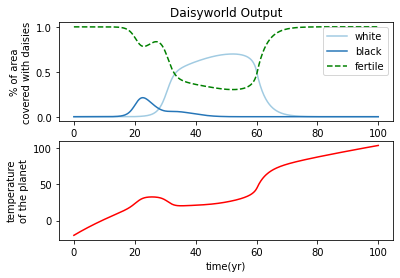

In [145]:
build_and_run()

## Interactive Part

In [146]:
# import libraries for interactive widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

Play around with the sliders to see how fertility, temperature and albedo influence the world model.

In [147]:
interactive_plot = interactive(build_and_run, fertility=(0, 1.5, .10), ltemp=(0, 100, 5), utemp=(0, 100, 5), walb=(0., 1., 0.05), balb=(0.,1.,0.05))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='fertility', max=1.5), IntSlider(value=5, description…